# Выбор локации для скважины

#Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных
Данные геологоразведки трёх регионов находятся в файлах:
`id` — уникальный идентификатор скважины;
`f0`, `f1` , `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
`product` — объём запасов в скважине (тыс. баррелей).

### Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### 0. Libraries

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

### 1.1. Data

In [2]:
base_path = r'E:\COURSES\Кодинг\[Yandex praxis]. DS specialist + (2022)\7\01 Машинное обучение в бизнесе\06 Самостоятельный проект'
geo_data = [pd.read_csv(f'{base_path}\\geo_data_{i}.csv') for i in range(3)]
geo_0, geo_1, geo_2 = geo_data

### 1.2. Basic information

In [3]:
def analyze_dataframe(df: pd.DataFrame, name: str) -> None:
    # Header
    print(f"ANALYSIS FOR GEO DATASET: {name.upper()}")
    print(f"{'=' * 50}")

    # 1. Basic Info
    print("\n[1] BASIC STATS:")
    display(df.info(verbose=False, memory_usage='deep'))

    # 2. ID Analysis (with column existence check)
    print("\n[2] ID ANALYSIS:")
    if 'id' in df.columns:
        print(f"• Unique IDs: {df['id'].nunique():,} ({(1 - df['id'].nunique()/len(df))*100:.1f}% duplicates)")
    else:
        print("• No 'id' column found.")

    # 3. Duplicates Analysis
    print("\n[3] DUPLICATES:")
    dupes = df.duplicated().sum()
    print(f"• Total duplicate rows: {dupes:,} ({(dupes/len(df))*100:.1f}% of data)")

    # 4. Statistical Summary
    print("\n[4] NUMERIC SUMMARY STATISTICS:")
    display(df.describe(include='all').T.style.format(precision=2))

    print("\n" + "=" * 50)

# Execute analysis for all dataframes
for i, df in enumerate(geo_data):
    analyze_dataframe(df, f"geo_{i}")


ANALYSIS FOR GEO DATASET: GEO_0

[1] BASIC STATS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 5 entries, id to product
dtypes: float64(4), object(1)
memory usage: 8.2 MB


None


[2] ID ANALYSIS:
• Unique IDs: 99,990 (0.0% duplicates)

[3] DUPLICATES:
• Total duplicate rows: 0 (0.0% of data)

[4] NUMERIC SUMMARY STATISTICS:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99990,fiKDv,2,nan,nan,nan,nan,nan,nan,nan
f0,100000.00,nan,nan,nan,0.50,0.87,-1.41,-0.07,0.50,1.07,2.36
f1,100000.00,nan,nan,nan,0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
f2,100000.00,nan,nan,nan,2.50,3.25,-12.09,0.29,2.52,4.72,16.00
product,100000.00,nan,nan,nan,92.50,44.29,0.00,56.50,91.85,128.56,185.36



ANALYSIS FOR GEO DATASET: GEO_1

[1] BASIC STATS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 5 entries, id to product
dtypes: float64(4), object(1)
memory usage: 8.2 MB


None


[2] ID ANALYSIS:
• Unique IDs: 99,996 (0.0% duplicates)

[3] DUPLICATES:
• Total duplicate rows: 0 (0.0% of data)

[4] NUMERIC SUMMARY STATISTICS:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,wt4Uk,2,nan,nan,nan,nan,nan,nan,nan
f0,100000.00,nan,nan,nan,1.14,8.97,-31.61,-6.30,1.15,8.62,29.42
f1,100000.00,nan,nan,nan,-4.80,5.12,-26.36,-8.27,-4.81,-1.33,18.73
f2,100000.00,nan,nan,nan,2.49,1.70,-0.02,1.00,2.01,4.00,5.02
product,100000.00,nan,nan,nan,68.83,45.94,0.00,26.95,57.09,107.81,137.95



ANALYSIS FOR GEO DATASET: GEO_2

[1] BASIC STATS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 5 entries, id to product
dtypes: float64(4), object(1)
memory usage: 8.2 MB


None


[2] ID ANALYSIS:
• Unique IDs: 99,996 (0.0% duplicates)

[3] DUPLICATES:
• Total duplicate rows: 0 (0.0% of data)

[4] NUMERIC SUMMARY STATISTICS:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,VF7Jo,2,nan,nan,nan,nan,nan,nan,nan
f0,100000.00,nan,nan,nan,0.00,1.73,-8.76,-1.16,0.01,1.16,7.24
f1,100000.00,nan,nan,nan,-0.00,1.73,-7.08,-1.17,-0.01,1.16,7.84
f2,100000.00,nan,nan,nan,2.50,3.47,-11.97,0.13,2.48,4.86,16.74
product,100000.00,nan,nan,nan,95.00,44.75,0.00,59.45,94.93,130.60,190.03


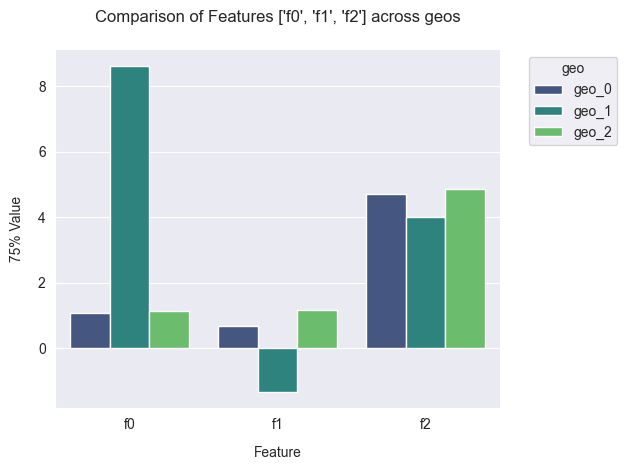

In [4]:
def q75(x):
    return np.quantile(x, 0.75)
features = ['f0',
            'f1',
            'f2']
estimator = '75%'
# Prepare the data (combine all datasets for comparison)
dfs = []
for i, df in enumerate(geo_data):
    df_melted = df[features].melt(var_name='Feature', value_name='Value')
    df_melted['geo'] = f'geo_{i}'
    dfs.append(df_melted)

combined_df = pd.concat(dfs)

sns.barplot(
    data=combined_df,
    x='Feature',
    y='Value',
    hue='geo',
    palette='viridis',
    errorbar=None,
    estimator=q75
)

plt.title(f'Comparison of Features {features} across geos', pad=20)
plt.xlabel('Feature', labelpad=10)
plt.ylabel(f'{estimator} Value', labelpad=10)
plt.legend(title='geo', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()  # Cleaner borders
plt.tight_layout()
plt.show()

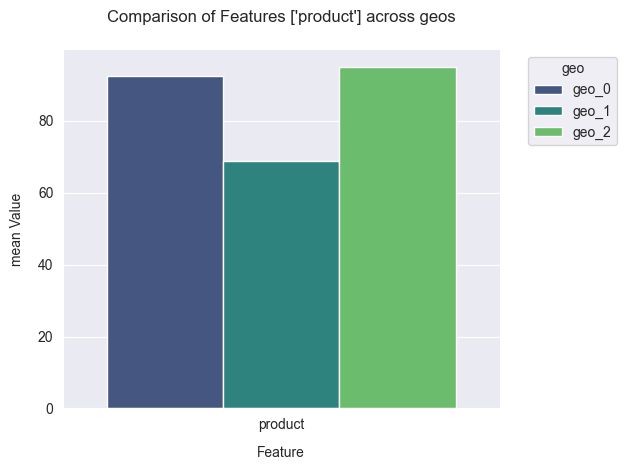

In [5]:
features = ['product']
estimator = 'mean'

dfs = []
for i, df in enumerate(geo_data):
    df_melted = df[features].melt(var_name='Feature', value_name='Value')
    df_melted['geo'] = f'geo_{i}'
    dfs.append(df_melted)

combined_df = pd.concat(dfs)

sns.barplot(
    data=combined_df,
    x='Feature',
    y='Value',
    hue='geo',
    palette='viridis',
    errorbar=None,
    estimator=estimator
)

plt.title(f'Comparison of Features {features} across geos', pad=20)
plt.xlabel('Feature', labelpad=10)
plt.ylabel(f'{estimator} Value', labelpad=10)
plt.legend(title='geo', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()  # Cleaner borders
plt.tight_layout()
plt.show()

### 1.3. Splitting

In [6]:
def splitting(df):
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']
    features_train, features_test, target_train, target_test = train_test_split(features,
                                                                                target,
                                                                                test_size=0.25,
                                                                                random_state=333
                                                                                )
    return features_train, features_test, target_train, target_test


base_path = r'E:\COURSES\Кодинг\[Yandex praxis]. DS specialist + (2022)\7\01 Машинное обучение в бизнесе\06 Самостоятельный проект'

try:
    splits = {}
    for i, df in enumerate([geo_0, geo_1, geo_2]):
        splits[f'geo_{i}'] = splitting(df)
        print(f"Successfully split geo_{i}")
except ValueError as e:
    print(f"Error: {e}")

Successfully split geo_0
Successfully split geo_1
Successfully split geo_2


### 1.4. Model

In [19]:
def train_and_evaluate(features_train, features_test, target_train, target_test):
    param_grid = {
        'linearregression__fit_intercept': [True, False],
        'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  # 'passthrough' means no scaling
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('linearregression', LinearRegression())
    ])

    grid_search_lr = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    grid_search_lr.fit(features_train, target_train)
    best_params = grid_search_lr.best_params_
    print(f"Best params: {best_params}")
    best_model = grid_search_lr.best_estimator_
    predictions = best_model.predict(features_test)
    metrics = {
        'rmse': np.sqrt(mean_squared_error(target_test, predictions)),
        'mae': mean_absolute_error(target_test, predictions),
        'r2': r2_score(target_test, predictions),
        'best_params': best_params,
        'coefficients': None,
        'model_type': 'LinearRegression',
        'product_mean_estimate' : best_model.predict(features_test).mean(),
        'product_mean_real' :target_test.mean()
    }

    try:
        metrics['coefficients'] = pd.DataFrame({
            'feature': features_train.columns,
            'coefficient': best_model.coef_
        }).sort_values('coefficient', key=abs, ascending=False)
    except Exception as e:
        print(f"Couldn't get coefficients: {str(e)}")

    return metrics, best_model

### 1.5. First prediction (evaluating pipeline)

In [20]:
final_results = {}
print("🚀 Starting Linear Regression Evaluation for All Regions\n")

for region_name, (X_train, X_test, y_train, y_test) in splits.items():
    try:
        print(f"\n📊 {'='*40}")
        print(f"🧭 REGION: {region_name.upper()}")
        print(f"📏 Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

        # Train and evaluate
        metrics, model = train_and_evaluate(X_train, X_test, y_train, y_test)
        final_results[region_name] = {'metrics': metrics, 'model': model}

        # Enhanced output formatting
        print(f"\n🔧 Best Model: {metrics['model_type']}")
        print(f"✅ RMSE: {metrics['rmse']:.4f} | MAE: {metrics['mae']:.4f} | R²: {metrics['r2']:.4f} | product estimated mean: {metrics['product_mean_estimate']:.4f}" )


    except Exception as e:
        print(f"❌ Error in {region_name}: {str(e)}")
        final_results[region_name] = {'error': str(e)}

# Final comparison with statistical summary
if final_results:
    print("\n🔥 FINAL COMPARISON ACROSS REGIONS")

    # Create a list of metrics dictionaries for each successful region
    metrics_list = []
    for region, data in final_results.items():
        if 'metrics' in data:
            metrics_data = data['metrics'].copy()
            metrics_data['region'] = region
            metrics_list.append(metrics_data)

    if metrics_list:
        # Create DataFrame from the list of dictionaries
        comparison_df = pd.DataFrame(metrics_list)

        # Set the index to be the region
        comparison_df = comparison_df.set_index('region')

        # Display the metrics we're interested in
        display_columns = ['model_type', 'rmse', 'mae', 'r2','product_mean_estimate','product_mean_real']
        display_df = comparison_df[display_columns]
        display(display_df.sort_values('rmse'))

🚀 Starting Linear Regression Evaluation for All Regions


📊 ========================================
🧭 REGION: GEO_0
📏 Train Shape: (75000, 3), Test Shape: (25000, 3)
Best params: {'linearregression__fit_intercept': True, 'scaler': StandardScaler()}
Couldn't get coefficients: 'Pipeline' object has no attribute 'coef_'

🔧 Best Model: LinearRegression
✅ RMSE: 37.5969 | MAE: 31.0210 | R²: 0.2744 | product estimated mean: 92.2541

📊 ========================================
🧭 REGION: GEO_1
📏 Train Shape: (75000, 3), Test Shape: (25000, 3)
Best params: {'linearregression__fit_intercept': True, 'scaler': 'passthrough'}
Couldn't get coefficients: 'Pipeline' object has no attribute 'coef_'

🔧 Best Model: LinearRegression
✅ RMSE: 0.8848 | MAE: 0.7142 | R²: 0.9996 | product estimated mean: 68.4688

📊 ========================================
🧭 REGION: GEO_2
📏 Train Shape: (75000, 3), Test Shape: (25000, 3)
Best params: {'linearregression__fit_intercept': True, 'scaler': 'passthrough'}
Couldn't get

,model_type,rmse,mae,r2,product_mean_estimate,product_mean_real
region,,,,,,
geo_1,LinearRegression,0.884794,0.714235,0.999630,68.468778,68.461665
geo_0,LinearRegression,37.596878,31.020960,0.274407,92.254138,92.515978
geo_2,LinearRegression,39.844212,32.564080,0.196378,95.123527,95.136111


### 1.4. Scaling train

In [9]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) = scaler.transform(features_train[numeric])

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (42605068.py, line 2)

## Подготовка к расчёту прибыли

## Расчёт прибыли и рисков 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован